In [344]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
mtx = np.array([[4.30832585e+03, 0.00000000e+00, 2.67770521e+03],
 [0.00000000, 4.33262975e+03, 1.80968008e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[-0.06455709,  0.64635224, -0.00222198, -0.00249137, -0.81607703]])

True

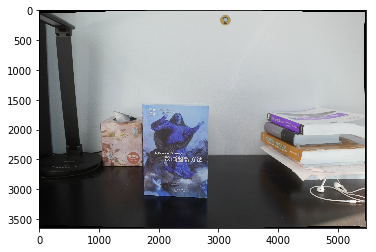

In [345]:
#part3 compute the relative camera pose
#undistortion
from PIL import Image
from pylab import *
import matplotlib.pyplot as plt
from scipy import optimize
img1 = cv2.imread('Part2/left.JPG')
img2 = cv2.imread('Part2/right.JPG')
h,  w = img1.shape[:2]
dist = np.array([-0.06455709,  0.64635224, -0.00222198, -0.00249137, -0.81607703])
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
dst1 = cv2.undistort(img1, mtx, dist, None, newcameramtx)
dst2 = cv2.undistort(img2, mtx, dist, None, newcameramtx)

imshow(dst1)
cv2.imwrite('dst1.jpg', dst1)
cv2.imwrite('dst2.jpg', dst2)

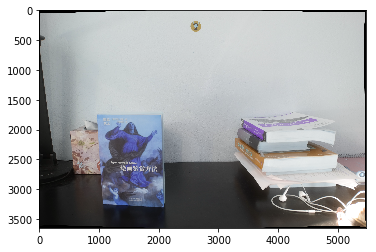

In [346]:
imshow(dst2)

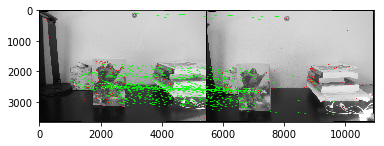

(<matplotlib.image.AxesImage at 0x12cf5f358>, None)

In [347]:
#undistorted = cv2.undistortPoints(corners2, mtx, dist) #P431
gray1= cv2.cvtColor(dst1,cv2.COLOR_BGR2GRAY)
gray2= cv2.cvtColor(dst2,cv2.COLOR_BGR2GRAY)
#SIFT 尺度不变特征变换
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None) #在步骤中直接查找关键点
kp2, des2 = sift.detectAndCompute(gray2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
#IndexParams
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5) 
#SearchParams,It specifies the number of times the trees in the index should be recursively traversed.
#Higher values gives better precision, but also takes more time.
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.35*n.distance:
        matchesMask[i]=[1,0]
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,matches,None,**draw_params)
cv2.imwrite('match.jpg', img3)
plt.imshow(img3,),plt.show()

In [348]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:2]
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

[[ 1.09575404e-08  5.24975027e-08 -9.48214856e-04]
 [ 4.96467995e-08 -2.40148086e-08 -7.45660564e-03]
 [ 6.11542063e-04  7.39773155e-03  1.00000000e+00]]


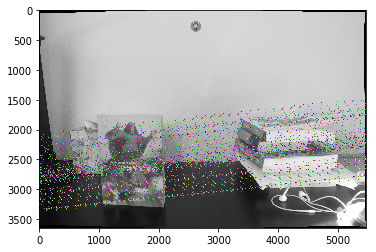

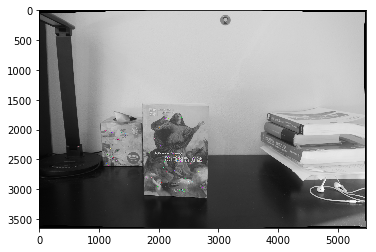

(<matplotlib.image.AxesImage at 0x12dc134a8>, None)

In [349]:
#find the Fundamental Matrix F
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2, cv2.FM_LMEDS)
print(F)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

#find the epilines
#Epilines corresponding to the points in first image is drawn on second image
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3) #未知分为行数3列
img5,img6 = drawlines(gray1,gray2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img7,img8 = drawlines(gray2,gray1,lines2,pts2,pts1)

cv2.imwrite('7.jpg', img7)
cv2.imwrite('8.jpg', img8)
plt.imshow(img7,),plt.show()
plt.imshow(img8,),plt.show()

In [350]:
E, mask = cv2.findEssentialMat(pts1,pts2,mtx)# 18.0, (0, 0))#
#print(mask)
print(E)
R1, R2, t = cv2.decomposeEssentialMat(E)
print(R1)
print(R2)
print(t)

[[ 0.00282497  0.00507503 -0.08230135]
 [ 0.02037956  0.00794088 -0.70194835]
 [ 0.07360727  0.70317349  0.01057753]]
[[ 0.9753888  -0.21958853  0.01993919]
 [-0.21926036 -0.97551119 -0.01740135]
 [ 0.02327204  0.0126012  -0.99964975]]
[[ 0.99931309  0.01205227  0.03504426]
 [-0.01244289  0.99986263  0.01094982]
 [-0.03490748 -0.01137835  0.99932577]]
[[-0.99316942]
 [ 0.11653434]
 [ 0.00585201]]


In [351]:
P21 = np.dot(mtx, np.hstack((R1, t)))
print(P21)
P22 = np.dot(mtx, np.hstack((R1, -t)))
print(P22)
P23 = np.dot(mtx, np.hstack((R2, t)))
print(P23)
P24 = np.dot(mtx, np.hstack((R2, -t)))
print(P24)
P0 = np.array([ [1,0,0,0],
                [0,1,0,0],
                [0,0,1,0] ])
print(mtx)

[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03 -4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03  5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01  5.85200604e-03]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]]
[[ 4.21189446e+03  2.14572298e+01  2.82688194e+03 -4.26322755e+03]
 [-1.17081790e+02  4.31144340e+03  1.85590145e+03  5.15490408e+02]
 [-3.49074793e-02 -1.13783482e-02  9.99325773e-01  5.85200604e-03]]
[[ 4.21189446e+03  2.14572298e+01  2.82688194e+03  4.26322755e+03]
 [-1.17081790e+02  4.31144340e+03  1.85590145e+03 -5.15490408e+02]
 [-3.49074793e-02 -1.13783482e-02  9.99325773e-01 -5.85200604e-03]]
[[4.30832585e+03 0.00000000e+00 2.67770521e+03]
 [0.00000000e+00 4.33262975e+03 1.80968008e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


[[ 657.0674 2285.2644]
 [1114.417  2220.98  ]
 [1115.517  2020.3525]
 [1132.546  2572.8535]
 [1140.5242 2299.4597]
 [1141.1699 2463.3093]
 [1148.3938 2581.6016]
 [1148.3938 2581.6016]
 [1148.3938 2581.6016]
 [1150.3403 2420.5232]
 [1151.8552 2330.9482]
 [1158.2448 2361.1013]
 [1165.587  2604.4941]
 [1172.7544 2494.3557]
 [1187.9913 2517.0947]
 [1189.123  2461.889 ]
 [1189.123  2461.889 ]
 [1192.5009 2426.3782]
 [1197.8137 2315.7097]
 [1200.1462 2255.7979]
 [1207.3312 2500.9998]
 [1207.6028 2284.7542]
 [1209.6322 2509.6865]
 [1214.4031 2406.547 ]
 [1216.2078 2053.2268]
 [1216.2872 2451.5698]
 [1220.7546 2496.6592]
 [1223.1931 2505.999 ]
 [1224.002  2570.6826]
 [1226.2594 2480.5999]
 [1227.6561 2456.4612]
 [1231.4874 2049.647 ]
 [1236.7974 2138.3167]
 [1240.2094 2531.4863]
 [1251.7992 2468.0305]
 [1252.4976 2393.5154]
 [1260.1129 2491.3323]
 [1264.4369 2396.2866]
 [1266.8132 2507.707 ]
 [1272.4911 2482.2986]
 [1285.7134 2380.7751]
 [1296.514  2518.0667]
 [1310.8452 2493.4927]
 [1311.5746

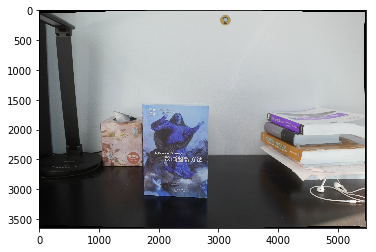

True

In [352]:
#pts1 = pts1[0:15]
#pts2 = pts2[0:15]
print(pts1)
print(pts2)
for pp1,pp2 in zip(pts1,pts2):
    print(pp1)
    cv2.circle(gray1,tuple(pp1),6,(255,0,0),6)
    cv2.circle(gray2,tuple(pp2),6,(255,0,0),6)

plt.imshow(dst1,),plt.show()
cv2.imwrite('9.jpg', gray1)
cv2.imwrite('10.jpg', gray2)
#print(pts1)
#print(pts2)
#print(P0)
#print(P21)


In [353]:
d1 = cv2.triangulatePoints(P0,P21,pts1.T, pts2.T)
d1 = d1/d1[3,:]
print(d1)

[[-2.04761624e+00 -3.19836640e+00 -2.16855145e+00 -5.76263428e+00
  -3.79613042e+00 -4.94331789e+00 -5.98633575e+00 -5.98633575e+00
  -5.98633575e+00 -4.68053865e+00 -4.05838060e+00 -4.30237150e+00
  -6.31436110e+00 -5.40822029e+00 -5.70821428e+00 -5.25477409e+00
  -5.25477409e+00 -5.00543690e+00 -4.22651577e+00 -3.83679843e+00
  -5.72620344e+00 -4.07136917e+00 -5.82584333e+00 -4.99851227e+00
  -2.70740151e+00 -5.37663364e+00 -5.79217005e+00 -5.88449574e+00
  -6.50375986e+00 -5.70332050e+00 -5.49883604e+00 -2.75576353e+00
  -3.29143715e+00 -6.26776505e+00 -5.79477072e+00 -5.16792011e+00
  -6.07154465e+00 -5.27826023e+00 -6.28130865e+00 -6.09550428e+00
  -5.31611013e+00 -6.66764879e+00 -6.54791737e+00 -5.25002480e+00
  -7.26247215e+00 -3.88158417e+00 -6.51973963e+00 -4.02012348e+00
  -7.70670128e+00 -8.07203674e+00 -8.07203674e+00 -3.75946832e+00
  -3.75946832e+00 -3.50978494e+00 -3.44872713e+00 -3.37438345e+00
  -3.48962593e+00 -3.37950826e+00 -4.25998402e+00 -4.25998402e+00
  -4.19493

In [354]:
d2 = cv2.triangulatePoints(P0,P22,pts1.T, pts2.T)
#print(d2)
d2 = d2/d2[3,:]
print(d2)

[[ 2.04761624e+00  3.19836640e+00  2.16855145e+00  5.76263428e+00
   3.79613042e+00  4.94331789e+00  5.98633575e+00  5.98633575e+00
   5.98633575e+00  4.68053865e+00  4.05838060e+00  4.30237150e+00
   6.31436110e+00  5.40822029e+00  5.70821428e+00  5.25477409e+00
   5.25477409e+00  5.00543690e+00  4.22651577e+00  3.83679843e+00
   5.72620344e+00  4.07136917e+00  5.82584333e+00  4.99851227e+00
   2.70740151e+00  5.37663364e+00  5.79217005e+00  5.88449574e+00
   6.50375986e+00  5.70332050e+00  5.49883604e+00  2.75576353e+00
   3.29143715e+00  6.26776505e+00  5.79477072e+00  5.16792011e+00
   6.07154465e+00  5.27826023e+00  6.28130865e+00  6.09550428e+00
   5.31611013e+00  6.66764879e+00  6.54791737e+00  5.25002480e+00
   7.26247215e+00  3.88158417e+00  6.51973963e+00  4.02012348e+00
   7.70670128e+00  8.07203674e+00  8.07203674e+00  3.75946832e+00
   3.75946832e+00  3.50978494e+00  3.44872713e+00  3.37438345e+00
   3.48962593e+00  3.37950826e+00  4.25998402e+00  4.25998402e+00
   4.19493

In [355]:
d3 = cv2.triangulatePoints(P0,P23,pts1.T, pts2.T)
#print(d3)
d3 = d3/d3[3,:]
print(d3)

[[-4.44609070e+00 -7.29980946e+00 -9.35626602e+00 -5.08890247e+00
  -6.84741306e+00 -5.74406719e+00 -5.11730051e+00 -5.11730051e+00
  -5.11730051e+00 -6.06291103e+00 -6.69257307e+00 -6.51348019e+00
  -5.05301142e+00 -5.71648741e+00 -5.66463566e+00 -6.00697517e+00
  -6.00697517e+00 -6.26630163e+00 -7.11537600e+00 -7.63768005e+00
  -5.85777950e+00 -7.44217348e+00 -5.82472610e+00 -6.53456640e+00
  -9.98227406e+00 -6.22722054e+00 -5.95381880e+00 -5.90852880e+00
  -5.50996351e+00 -6.09657192e+00 -6.26085329e+00 -1.02029247e+01
  -9.13754272e+00 -5.83554983e+00 -6.31878805e+00 -6.86765671e+00
  -6.20604229e+00 -6.92101955e+00 -6.13112831e+00 -6.34396553e+00
  -7.19809580e+00 -6.22115612e+00 -6.47958565e+00 -7.65119553e+00
  -6.01389217e+00 -9.55721951e+00 -6.61079407e+00 -9.67070293e+00
  -6.02142143e+00 -6.14988422e+00 -6.14988422e+00 -1.11769276e+01
  -1.11769276e+01 -1.20971165e+01 -1.23844128e+01 -1.26219797e+01
  -1.28287048e+01 -1.31659460e+01 -1.10484886e+01 -1.10484886e+01
  -1.15956

In [356]:
d4 = cv2.triangulatePoints(P0,P24,pts1.T, pts2.T)
#print(d4)
d4 = d4/d4[3,:]
print(d4)

[[ 4.44609070e+00  7.29980946e+00  9.35626602e+00  5.08890247e+00
   6.84741306e+00  5.74406719e+00  5.11730051e+00  5.11730051e+00
   5.11730051e+00  6.06291103e+00  6.69257307e+00  6.51348019e+00
   5.05301142e+00  5.71648741e+00  5.66463566e+00  6.00697517e+00
   6.00697517e+00  6.26630163e+00  7.11537600e+00  7.63768005e+00
   5.85777950e+00  7.44217348e+00  5.82472610e+00  6.53456640e+00
   9.98227406e+00  6.22722054e+00  5.95381880e+00  5.90852880e+00
   5.50996351e+00  6.09657192e+00  6.26085329e+00  1.02029247e+01
   9.13754272e+00  5.83554983e+00  6.31878805e+00  6.86765671e+00
   6.20604229e+00  6.92101955e+00  6.13112831e+00  6.34396553e+00
   7.19809580e+00  6.22115612e+00  6.47958565e+00  7.65119553e+00
   6.01389217e+00  9.55721951e+00  6.61079407e+00  9.67070293e+00
   6.02142143e+00  6.14988422e+00  6.14988422e+00  1.11769276e+01
   1.11769276e+01  1.20971165e+01  1.23844128e+01  1.26219797e+01
   1.28287048e+01  1.31659460e+01  1.10484886e+01  1.10484886e+01
   1.15956

In [357]:
d = np.dot(P22, d2)
#d = np.dot(mtx, d3[:3])#4[:3])
d = d/d[2,:]
d = d[:2]
print(d)

[[ 212.76649541  612.80588134  606.83357905  644.37725176  639.95644761
   647.8756283   661.86175042  661.86175042  661.86175042  654.70618029
   652.13589904  659.57664817  676.07885812  678.95988441  694.78834415
   692.7155112   692.7155112   695.44198972  695.83863641  695.69632925
   712.54122637  703.99697973  716.28389107  715.22912219  703.26487259
   718.81332087  724.83447465  727.08169983  731.02343281  730.55511733
   729.78037376  718.29591507  726.42348223  745.02848934  753.80374902
   751.08809172  762.73262661  762.45076916  769.78324668  774.73705199
   783.37919437  799.53064138  811.86190725  806.86613465  816.34458623
   800.60868281  819.618633    817.43435897  840.06917245  868.13301393
   868.13301393  855.72408155  855.72408155  865.28701691  868.94217182
   869.4676906   886.38154665  886.22012807  892.22494455  892.22494455
   906.43602736  906.43602736  911.36937482  918.30127988  924.85805252
   926.3906085   926.70677097  939.76048263  930.15252983  947.7

In [358]:
print(d.T)
print(pts2)

[[ 212.76649541 2423.72064274]
 [ 612.80588134 2361.96580872]
 [ 606.83357905 2164.20752417]
 [ 644.37725176 2707.95506043]
 [ 639.95644761 2439.76415421]
 [ 647.8756283  2601.13939316]
 [ 661.86175042 2717.28566793]
 [ 661.86175042 2717.28566793]
 [ 661.86175042 2717.28566793]
 [ 654.70618029 2558.78954112]
 [ 652.13589904 2470.03682435]
 [ 659.57664817 2499.99461473]
 [ 676.07885812 2740.2485132 ]
 [ 678.95988441 2631.71902125]
 [ 694.78834415 2652.93994306]
 [ 692.7155112  2599.22604763]
 [ 692.7155112  2599.22604763]
 [ 695.44198972 2564.37699313]
 [ 695.83863641 2455.29056948]
 [ 695.69632925 2396.04689515]
 [ 712.54122637 2637.79666371]
 [ 703.99697973 2424.56393468]
 [ 716.28389107 2645.83276368]
 [ 715.22912219 2544.53001706]
 [ 703.26487259 2195.9145368 ]
 [ 718.81332087 2589.33328462]
 [ 724.83447465 2633.52074923]
 [ 727.08169983 2642.03563588]
 [ 731.02343281 2706.57881661]
 [ 730.55511733 2617.45773427]
 [ 729.78037376 2593.67625515]
 [ 718.29591507 2192.39914686]
 [ 726.4

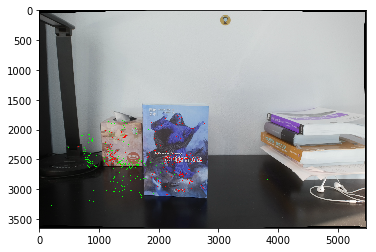

True

In [275]:
df = np.float32(d)
for pp1,pp2 in zip(pts1,df.T):
    #print(pp1)
    cv2.circle(dst1,tuple(pp1),6,(255,0,0),6)
    cv2.circle(dst1,tuple(pp2),6,(0,255,0),6)
plt.imshow(dst1,),plt.show()
cv2.imwrite('12.jpg', dst1)

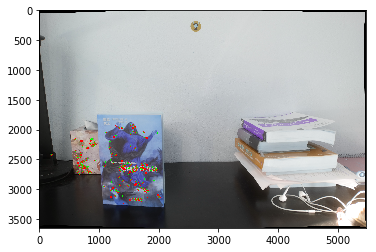

True

In [467]:
df = np.float32(d)
for pp1,pp2 in zip(pts2,df.T):
    #print(pp1)
    cv2.circle(dst2,tuple(pp1),10,(255,0,0),10)
    cv2.circle(dst2,tuple(pp2),6,(0,255,0),6)
plt.imshow(dst2,),plt.show()
cv2.imwrite('13.jpg', dst2)

In [582]:
#part 4
distance = []
for i in range(20):
    distance.append(5 + i * 37)
print(distance)

[5, 42, 79, 116, 153, 190, 227, 264, 301, 338, 375, 412, 449, 486, 523, 560, 597, 634, 671, 708]


[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0. -1.  5.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  5.00000000e+00]]
[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.2 0.2]]
[[ 0.99931309 -0.01244289 -0.23354136]
 [ 0.01205227  0.99986263  0.01192852]
 [ 0.03504426  0.01094982  1.00049617]]
[[  0.99931309  -0.         388.66979962]
 [  0.           0.99986263  -9.01651251]
 [  0.           0.           1.00049617]]


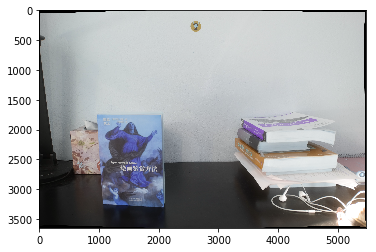

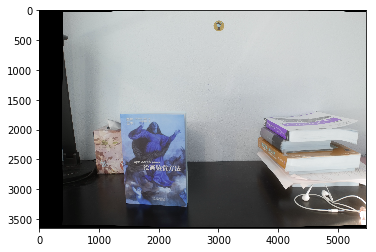

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0. -1. 42.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  4.20000000e+01]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.02380952 0.02380952]]
[[ 0.99931309 -0.01244289 -0.05855437]
 [ 0.01205227  0.99986263 -0.00860372]
 [ 0.03504426  0.01094982  0.99946511]]
[[ 0.99931309 -0.         97.44875599]
 [ 0.          0.99986263  6.50336843]
 [ 0.          0.          0.99946511]]


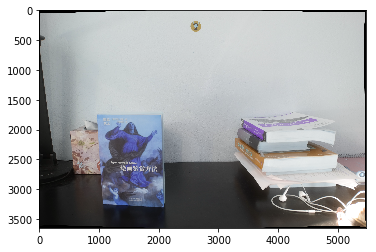

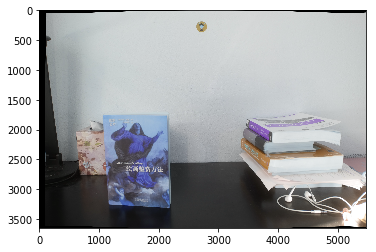

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0. -1. 79.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  7.90000000e+01]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.01265823 0.01265823]]
[[ 0.99931309 -0.01244289 -0.04747924]
 [ 0.01205227  0.99986263 -0.00990323]
 [ 0.03504426  0.01094982  0.99939985]]
[[ 0.99931309 -0.         79.01704437]
 [ 0.          0.99986263  7.48563937]
 [ 0.          0.          0.99939985]]


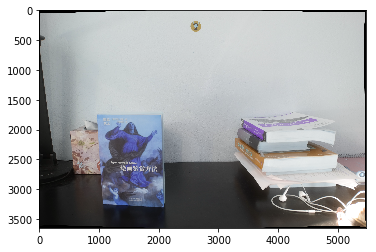

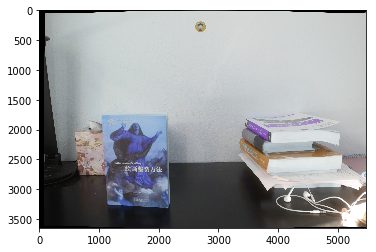

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 116.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  1.16000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00862069 0.00862069]]
[[ 0.99931309 -0.01244289 -0.04346928]
 [ 0.01205227  0.99986263 -0.01037374]
 [ 0.03504426  0.01094982  0.99937622]]
[[ 0.99931309 -0.         72.34349361]
 [ 0.          0.99986263  7.8412892 ]
 [ 0.          0.          0.99937622]]


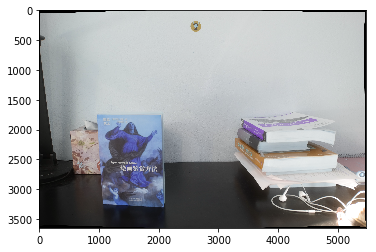

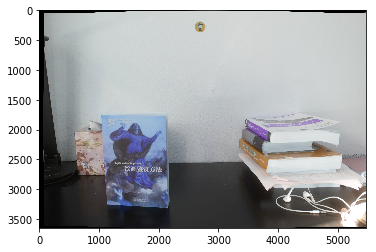

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 153.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  1.53000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00653595 0.00653595]]
[[ 0.99931309 -0.01244289 -0.04139878]
 [ 0.01205227  0.99986263 -0.01061669]
 [ 0.03504426  0.01094982  0.99936402]]
[[ 0.99931309 -0.         68.89767328]
 [ 0.          0.99986263  8.02492538]
 [ 0.          0.          0.99936402]]


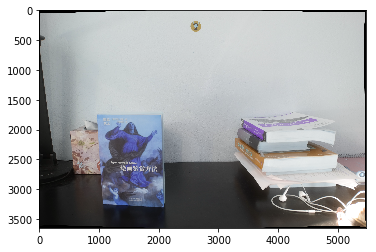

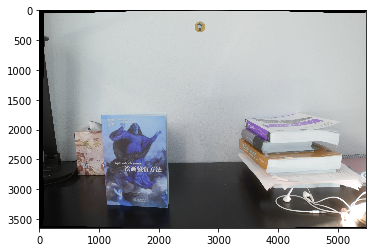

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 190.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  1.90000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00526316 0.00526316]]
[[ 0.99931309 -0.01244289 -0.04013469]
 [ 0.01205227  0.99986263 -0.01076501]
 [ 0.03504426  0.01094982  0.99935657]]
[[ 0.99931309 -0.         66.79390929]
 [ 0.          0.99986263  8.1370401 ]
 [ 0.          0.          0.99935657]]


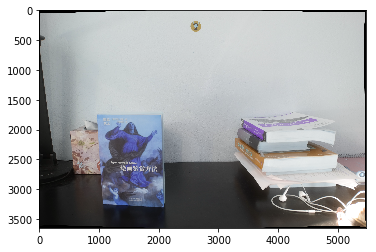

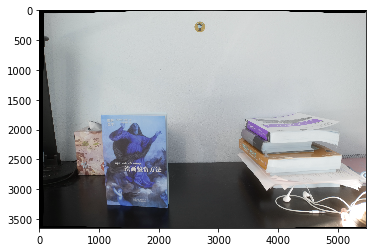

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 227.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  2.27000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00440529 0.00440529]]
[[ 0.99931309 -0.01244289 -0.03928267]
 [ 0.01205227  0.99986263 -0.01086498]
 [ 0.03504426  0.01094982  0.99935155]]
[[ 0.99931309 -0.         65.37595383]
 [ 0.          0.99986263  8.21260641]
 [ 0.          0.          0.99935155]]


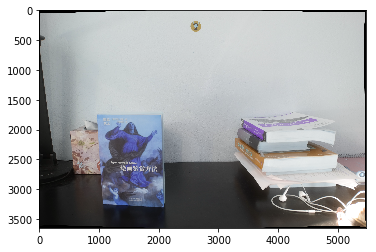

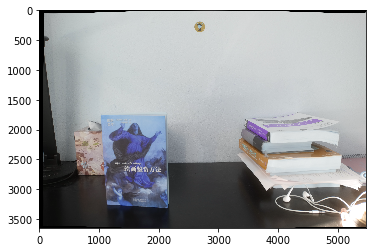

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 264.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  2.64000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00378788 0.00378788]]
[[ 0.99931309 -0.01244289 -0.03866948]
 [ 0.01205227  0.99986263 -0.01093693]
 [ 0.03504426  0.01094982  0.99934794]]
[[ 0.99931309 -0.         64.35545557]
 [ 0.          0.99986263  8.26699126]
 [ 0.          0.          0.99934794]]


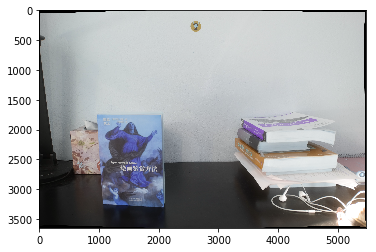

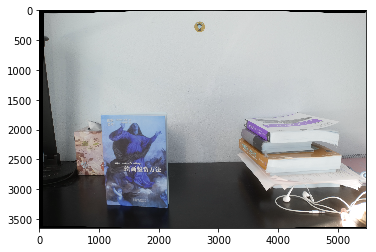

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 301.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  3.01000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00332226 0.00332226]]
[[ 0.99931309 -0.01244289 -0.03820705]
 [ 0.01205227  0.99986263 -0.01099119]
 [ 0.03504426  0.01094982  0.99934522]]
[[ 0.99931309 -0.         63.58584394]
 [ 0.          0.99986263  8.30800574]
 [ 0.          0.          0.99934522]]


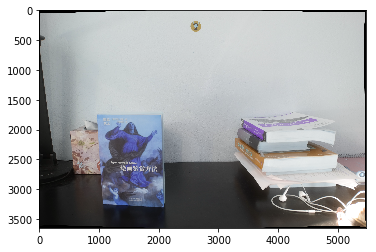

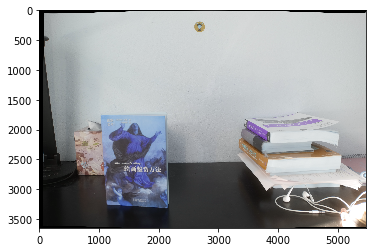

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 338.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  3.38000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00295858 0.00295858]]
[[ 0.99931309 -0.01244289 -0.03784585]
 [ 0.01205227  0.99986263 -0.01103357]
 [ 0.03504426  0.01094982  0.99934309]]
[[ 0.99931309 -0.         62.98472716]
 [ 0.          0.99986263  8.34004073]
 [ 0.          0.          0.99934309]]


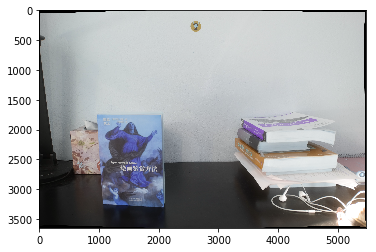

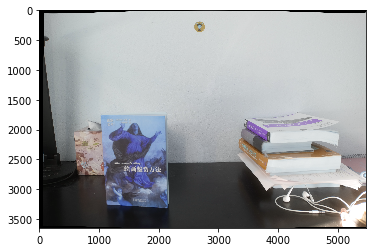

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 375.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  3.75000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00266667 0.00266667]]
[[ 0.99931309 -0.01244289 -0.03755593]
 [ 0.01205227  0.99986263 -0.01106759]
 [ 0.03504426  0.01094982  0.99934138]]
[[ 0.99931309 -0.         62.50223075]
 [ 0.          0.99986263  8.36575414]
 [ 0.          0.          0.99934138]]


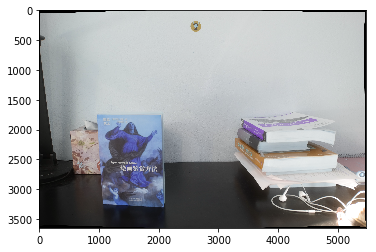

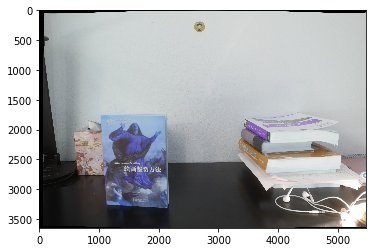

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 412.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  4.12000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00242718 0.00242718]]
[[ 0.99931309 -0.01244289 -0.03731808]
 [ 0.01205227  0.99986263 -0.0110955 ]
 [ 0.03504426  0.01094982  0.99933998]]
[[ 0.99931309 -0.         62.10639632]
 [ 0.          0.99986263  8.38684912]
 [ 0.          0.          0.99933998]]


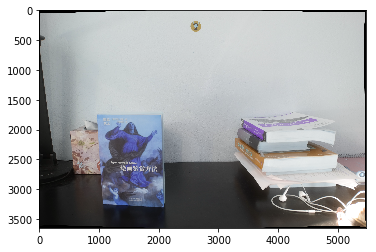

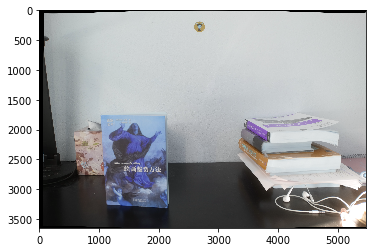

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 449.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  4.49000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00222717 0.00222717]]
[[ 0.99931309 -0.01244289 -0.03711944]
 [ 0.01205227  0.99986263 -0.01111881]
 [ 0.03504426  0.01094982  0.99933881]]
[[ 0.99931309 -0.         61.77579964]
 [ 0.          0.99986263  8.40446743]
 [ 0.          0.          0.99933881]]


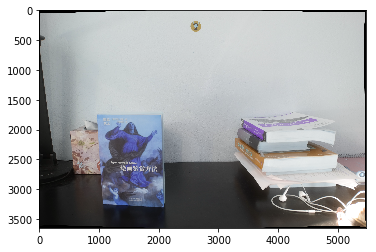

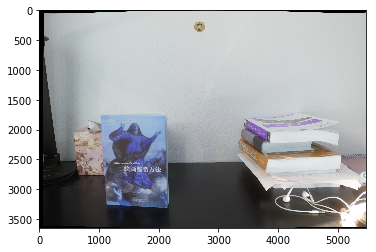

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 486.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  4.86000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00205761 0.00205761]]
[[ 0.99931309 -0.01244289 -0.03695104]
 [ 0.01205227  0.99986263 -0.01113857]
 [ 0.03504426  0.01094982  0.99933781]]
[[ 0.99931309 -0.         61.49554072]
 [ 0.          0.99986263  8.41940311]
 [ 0.          0.          0.99933781]]


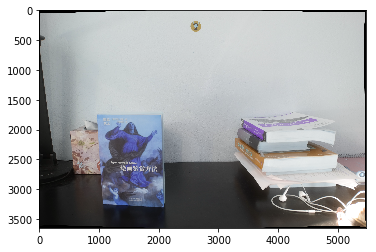

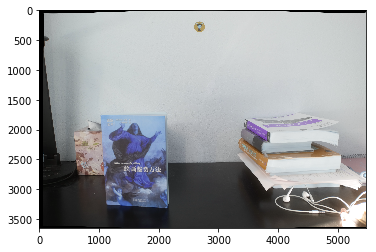

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 523.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  5.23000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00191205 0.00191205]]
[[ 0.99931309 -0.01244289 -0.03680646]
 [ 0.01205227  0.99986263 -0.01115553]
 [ 0.03504426  0.01094982  0.99933696]]
[[ 0.99931309 -0.         61.25493603]
 [ 0.          0.99986263  8.43222552]
 [ 0.          0.          0.99933696]]


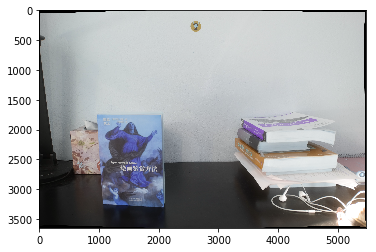

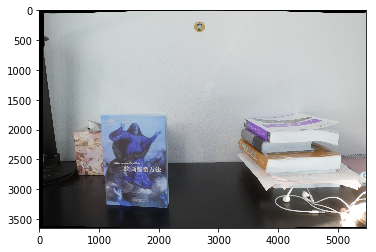

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 560.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  5.60000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00178571 0.00178571]]
[[ 0.99931309 -0.01244289 -0.036681  ]
 [ 0.01205227  0.99986263 -0.01117025]
 [ 0.03504426  0.01094982  0.99933622]]
[[ 0.99931309 -0.         61.04612553]
 [ 0.          0.99986263  8.44335354]
 [ 0.          0.          0.99933622]]


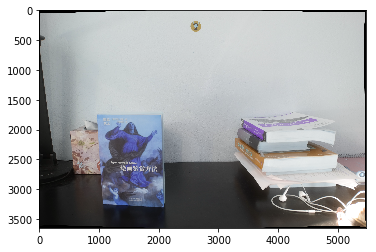

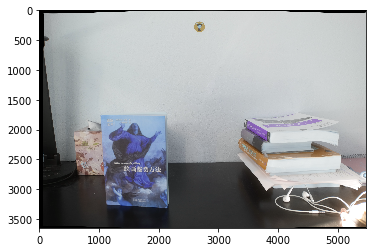

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 597.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  5.97000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00167504 0.00167504]]
[[ 0.99931309 -0.01244289 -0.03657108]
 [ 0.01205227  0.99986263 -0.01118315]
 [ 0.03504426  0.01094982  0.99933558]]
[[ 0.99931309 -0.         60.86319774]
 [ 0.          0.99986263  8.45310221]
 [ 0.          0.          0.99933558]]


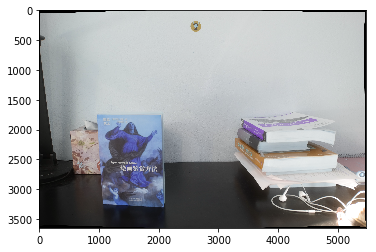

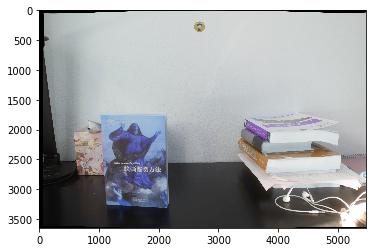

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 634.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  6.34000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00157729 0.00157729]]
[[ 0.99931309 -0.01244289 -0.03647399]
 [ 0.01205227  0.99986263 -0.01119454]
 [ 0.03504426  0.01094982  0.999335  ]]
[[ 0.99931309 -0.         60.70162114]
 [ 0.          0.99986263  8.46171302]
 [ 0.          0.          0.999335  ]]


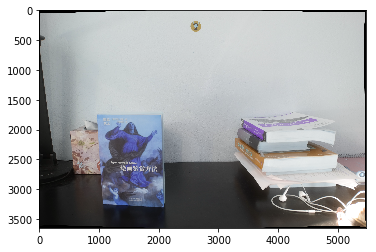

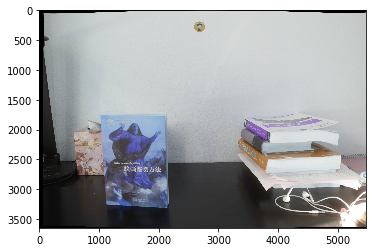

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 671.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  6.71000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00149031 0.00149031]]
[[ 0.99931309 -0.01244289 -0.03638761]
 [ 0.01205227  0.99986263 -0.01120468]
 [ 0.03504426  0.01094982  0.99933449]]
[[ 0.99931309 -0.         60.55786372]
 [ 0.          0.99986263  8.46937421]
 [ 0.          0.          0.99933449]]


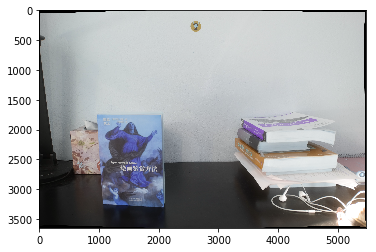

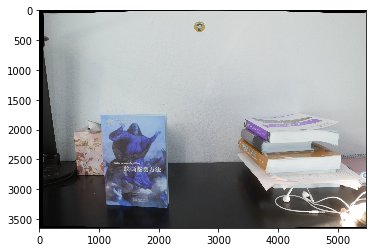

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.  -1. 708.]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  7.08000000e+02]]
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.00141243 0.00141243]]
[[ 0.99931309 -0.01244289 -0.03631026]
 [ 0.01205227  0.99986263 -0.01121375]
 [ 0.03504426  0.01094982  0.99933404]]
[[ 0.99931309 -0.         60.4291318 ]
 [ 0.          0.99986263  8.47623465]
 [ 0.          0.          0.99933404]]


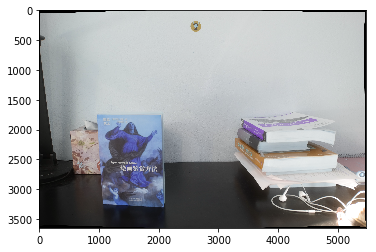

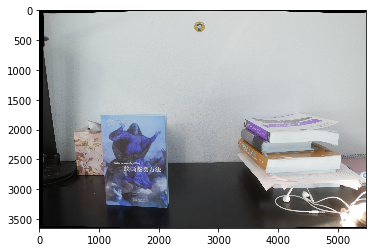

In [583]:
dst2 = cv2.undistort(img2, mtx, dist, None, newcameramtx)
for test in distance:
#test = 3665
    pOne = np.array([ [1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,-1,test]])
    pOne = np.float32(pOne)
    print(pOne)
    pTwo = np.array([[ 4.26460842e+03, -9.12316630e+02, -2.59086283e+03,4.26322755e+03],
           [-9.07859026e+02, -4.20372467e+03, -1.88443983e+03,-5.15490408e+02],
           [ 2.32720351e-02,  1.26012045e-02, -9.99649750e-01,-5.85200604e-03],
           [0,0,-1,test]])
    print(pTwo)
    pOneInv = np.linalg.inv(pOne)
    print(pOneInv)
    H = pTwo * pOneInv
    #H = H[:3, :3]
    #print(H)
    H = R2.T - (t) * (np.array([0, 0, -1]).T) / test
    print(H)
    mat = mtx * H * np.linalg.inv(mtx)

    print(mat)
    h,  w = img1.shape[:2]
    H12 = np.array([[0.919727,0.079438,2050.097540],[0.017547,0.933297,32.024847],[0.000012,0.000003,1.000000]])
    warped = cv2.warpPerspective(dst2,mat,(w,h))
    #test = np.dot(mat, [783.37919437, 2518.51272543])
    plt.imshow(dst2),plt.show()
    plt.imshow(warped,),plt.show()
    cv2.imwrite('warped1/warped' + str(test) + '.jpg', warped)

In [576]:
dst2 = cv2.undistort(img2, mtx, dist, None, newcameramtx)
test = 3665
pOne = np.array([ [1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,-1,test]])
pOne = np.float32(pOne)
print(pOne)
pTwo = np.array([[ 4.26460842e+03, -9.12316630e+02, -2.59086283e+03,4.26322755e+03],
           [-9.07859026e+02, -4.20372467e+03, -1.88443983e+03,-5.15490408e+02],
           [ 2.32720351e-02,  1.26012045e-02, -9.99649750e-01,-5.85200604e-03],
           [0,0,-1,test]])
print(pTwo)


[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.000e+00  3.665e+03]]
[[ 4.26460842e+03 -9.12316630e+02 -2.59086283e+03  4.26322755e+03]
 [-9.07859026e+02 -4.20372467e+03 -1.88443983e+03 -5.15490408e+02]
 [ 2.32720351e-02  1.26012045e-02 -9.99649750e-01 -5.85200604e-03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  3.66500000e+03]]


In [577]:
pOneInv = np.linalg.inv(pOne)
print(pOneInv)

[[1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 2.728513e-04 2.728513e-04]]


In [578]:
H = pTwo * pOneInv
#H = H[:3, :3]
#print(H)
H = R2.T - (t) * (np.array([0, 0, -1]).T) / test
print(H)
mat = mtx * H * np.linalg.inv(mtx)

print(mat)

[[ 0.99931309 -0.01244289 -0.03517847]
 [ 0.01205227  0.99986263 -0.01134655]
 [ 0.03504426  0.01094982  0.99932737]]
[[ 0.99931309 -0.         58.54555031]
 [ 0.          0.99986263  8.57661531]
 [ 0.          0.          0.99932737]]


3648
5472


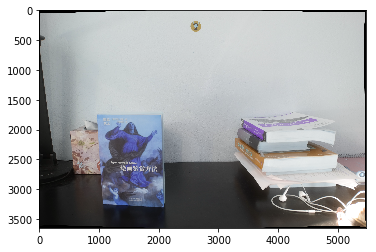

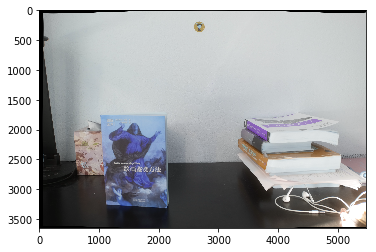

True

In [579]:
h,  w = img1.shape[:2]
print(h)
print(w)
H12 = np.array([[0.919727,0.079438,2050.097540],[0.017547,0.933297,32.024847],[0.000012,0.000003,1.000000]])
warped = cv2.warpPerspective(dst2,mat,(w,h))
#test = np.dot(mat, [783.37919437, 2518.51272543])
plt.imshow(dst2),plt.show()
plt.imshow(warped,),plt.show()
cv2.imwrite('warped1/warped3665.jpg', warped)